<h2>Training an image classifier</h2?

<h3>1. Loading and normalizing CIFAR10</h3>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# imgs should be unnormalized to be displayed!

In [5]:
trainset = torchvision.datasets.CIFAR10(root="./data", train=True, 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoaderader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root="./data", train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


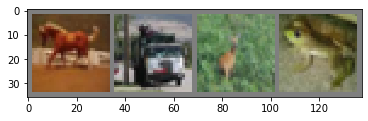

horse  truck   deer   frog 


In [10]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize!
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# gets some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# shows images
imshow(torchvision.utils.make_grid(images))
# prints labels
print(" ".join("%5s " % classes[labels[j]] for j in range(4)))

<h3>2. Define a Convolutional Neural Network</h2>